In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import plotly.express as px
import time 
import matplotlib.cm as cm
import glob
from PIL import Image

import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point

from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,8)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [2]:
df = pd.read_csv('../data/polarbears/pB_2009_2016.csv')

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
df.columns

Index(['bear_id', 'GMTdate', 'GMTtime', 'long', 'lat', 'raw_act',
       'standard_act', 'active_den', 'habitat', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11'],
      dtype='object')

In [4]:
df = df[['bear_id', 'GMTdate', 'GMTtime', 'long', 'lat', 'raw_act',
       'standard_act', 'active_den', 'habitat']]

In [5]:
df.head()

,bear_id,GMTdate,GMTtime,long,lat,raw_act,standard_act,active_den,habitat
0,pb_20132,4/29/2009,8:30:00,-148.032689,70.525736,131.0,131.0,0,land
1,pb_20132,4/29/2009,9:00:00,-148.032737,70.525732,194.0,194.0,0,land
2,pb_20132,4/29/2009,9:30:00,-148.032779,70.525775,9.0,9.0,0,land
3,pb_20132,4/29/2009,10:00:00,-148.032822,70.525818,205.0,205.0,0,land
4,pb_20132,4/29/2009,10:30:00,-148.032792,70.525817,542.0,542.0,0,land


# Data Preprocessing

In [6]:
#Convert GMTdate to datetime format
df["GMTdate"]=pd.to_datetime(df["GMTdate"])

In [7]:
df_bear = df[['long', 'lat']].copy()
df_bear.describe()

,long,lat
count,342315.000000,342315.000000
mean,-150.088306,72.269733
std,18.308645,2.057010
min,-179.999223,67.600147
25%,-156.730057,70.855472
50%,-150.086171,71.553908
75%,-146.100000,73.247342
max,179.988453,82.541490


In [8]:
# Drop lat/longs of extreme outliers below 0.01 percentile or above 99.99 percentile
df_bear_filtered = df_bear[(df_bear.quantile(0.0001) < df_bear) & (df_bear < df_bear.quantile(0.9999))]
df_bear_filtered = df_bear_filtered.dropna(how='any')

print(f'{df_bear.shape[0] - df_bear_filtered.shape[0]} extreme outliers removed')
print(f'Shape of filtered df_pickup: {df_bear_filtered.shape}')

140 extreme outliers removed
Shape of filtered df_pickup: (342175, 2)


## plot coordinates and clusters onto Map of Arctic Circle

In [9]:
def plot_geolocation_by_cluster(df,cluster,title,centers,filename):
    
    
    # Transform df into geodataframe
    geo_df = gpd.GeoDataFrame(df.drop(['long', 'lat'], axis=1),
                           crs={'init': 'epsg:4326'},
                           geometry=[Point(xy) for xy in zip(df.long, df.lat)])
      
    # Set figure size
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_aspect('equal')
    
    # Import ArcticShape Files
    world_full = gpd.read_file("../data/shapefiles/arctic_full.shp")
    world_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)
    
    # Plot coordinates from geo_df on top of NYC map
    if cluster is not None:
        geo_df.plot(ax=ax, column=cluster, alpha=0.5, 
                    cmap='viridis', linewidth=0.8, zorder=2)
        if centers is not None:
            centers_gseries = GeoSeries(map(Point, zip(centers[:,0], centers[:,1])))
            centers_gseries.plot(ax=ax, alpha=0.8, color='black', markersize=100, zorder=3)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.ylim(50, 90)
        plt.xlim(-180, -100)
        plt.show()
        

        
        
        if filename is not None:
            fig.savefig(f'{filename}', bbox_inches='tight', dpi=300)
    else:
        geo_df.plot(ax=ax, alpha=0.5, cmap='viridis', linewidth=0.8, legend=True, zorder=2)
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.ylim(50, 90)
        plt.show()
        
        
    fig.clf()
 

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



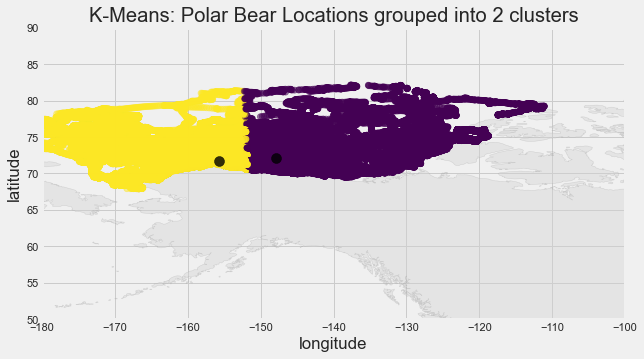

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



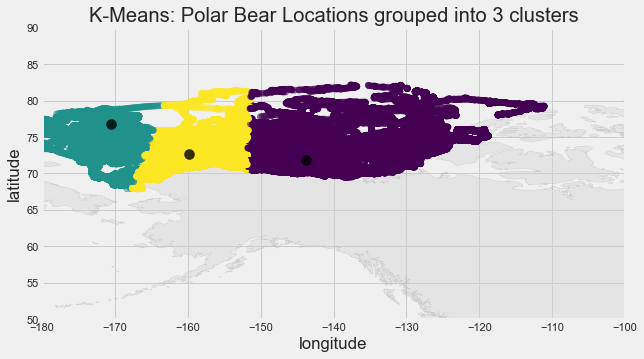

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



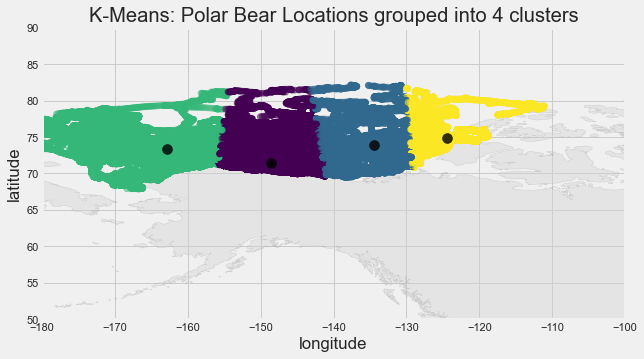

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



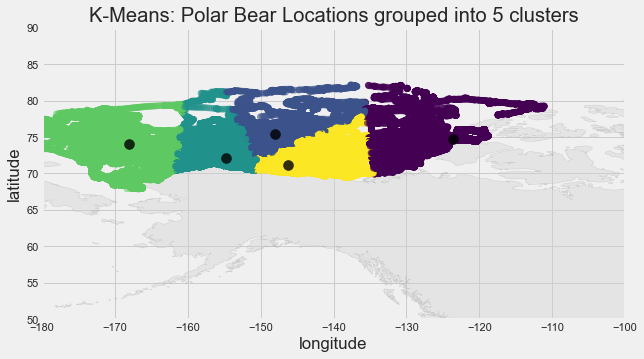

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



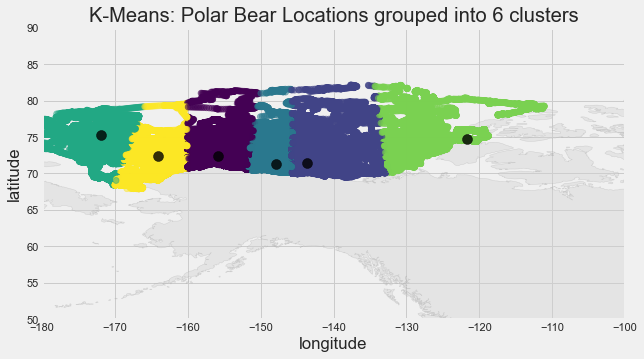

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



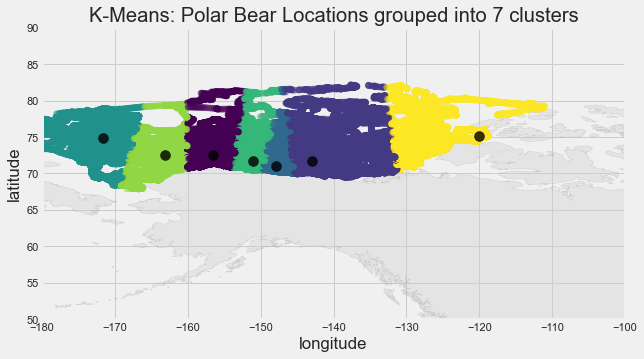

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



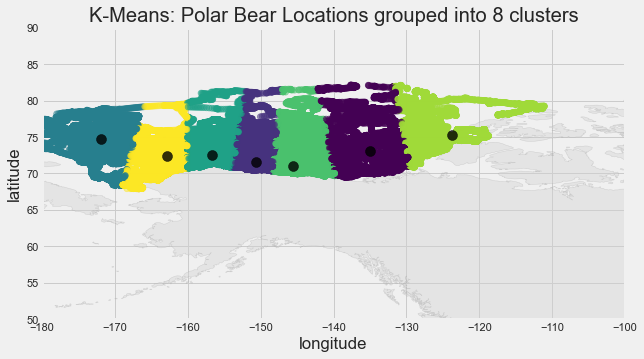

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



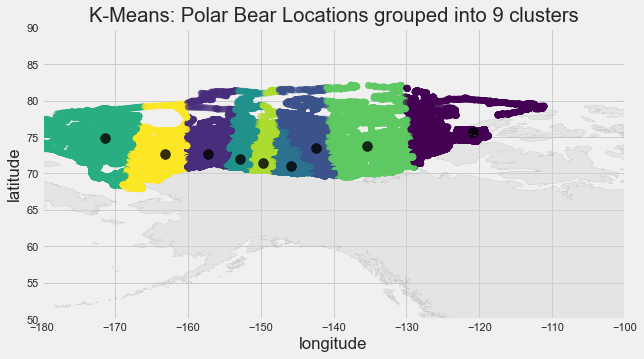

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



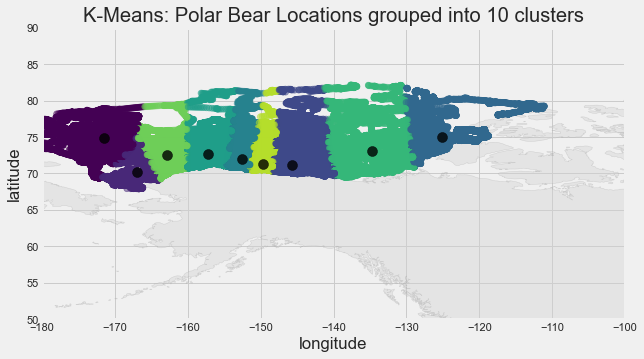

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



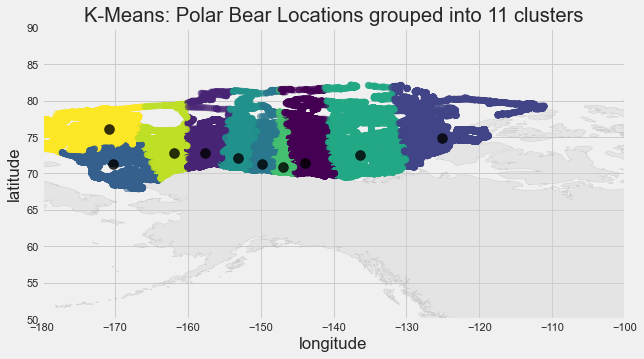

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



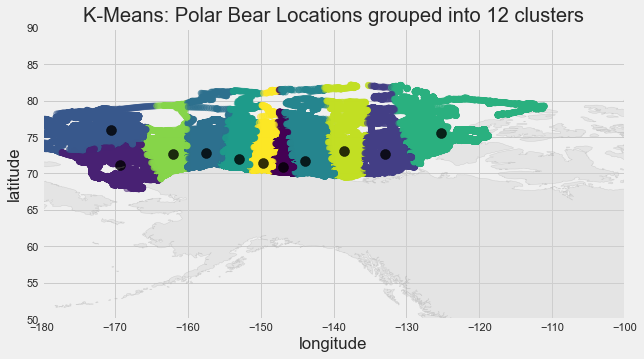

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



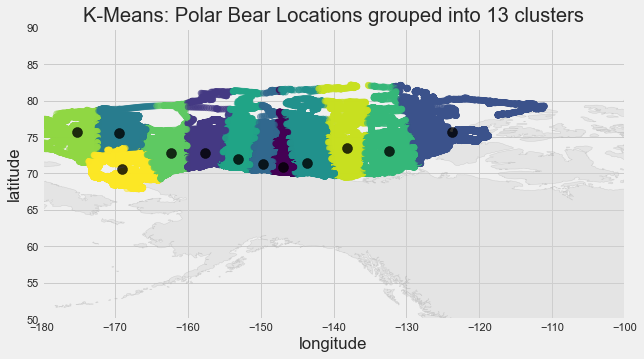

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



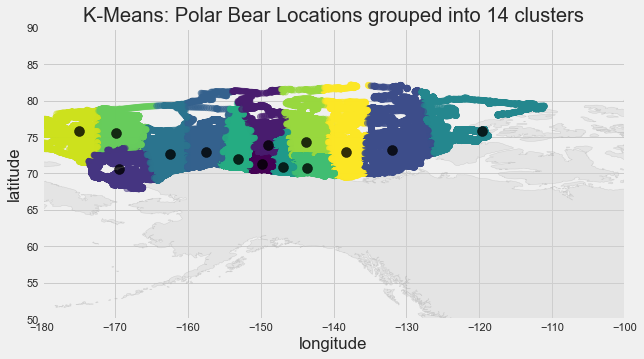

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



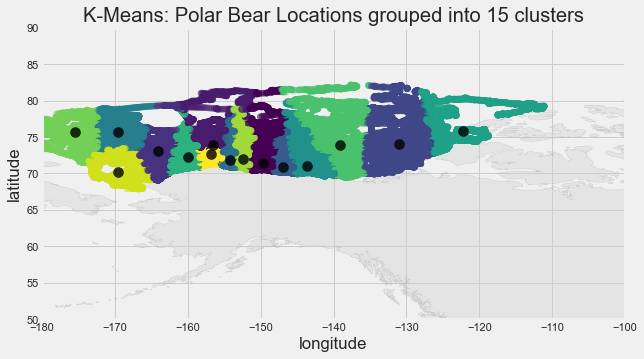

In [10]:
ssd = []

for i in range(2, 16):
    # Find clusters
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(df_bear_filtered)
    
    # Label cluster centers
    centers = km.cluster_centers_
    
    # Calculate sum of squared distances
    ssd.append(km.inertia_)
    
    # Get cluster center
    df_bear_filtered['cluster'] = km.labels_
    
    # Plot lat/long and clusters on map
    plot_geolocation_by_cluster(df_bear_filtered, cluster='cluster', title= f'K-Means: Polar Bear Locations grouped into {i} clusters', centers=centers, filename=f'../ML_notebooks/plots/bear_kmeans_{i}_clusters.png')

In [11]:
def png_to_gif(path_to_images, save_file_path, duration=500):
    frames = []
    images = glob.glob(f'{path_to_images}')
    
    for i in sorted(images): 
        im = Image.open(i)
        im = im.resize((550,389),Image.ANTIALIAS)
        frames.append(im.copy())
    
    frames[0].save(f'{save_file_path}', format='GIF', append_images=frames[1:], save_all=True,
                   duration=duration, loop=0)


In [12]:
png_to_gif(path_to_images='../ML_notebooks/plots/*.png', 
           save_file_path='../ML_notebooks/plots/bear_kmeans_clusters.gif',
           duration=1000)



In [13]:
from IPython.display import HTML
HTML('<img src="../ML_notebooks/plots/bear_kmeans_clusters.gif">')